In [3]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.6/620.6 MB 267.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 285.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 228.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 240.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 136.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 282.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 199.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 229.4 MB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to us

In [6]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 320.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 227.5 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Cell 0: Force TensorFlow to use CPU only (must run BEFORE importing tensorflow)

import os

# Hide all GPUs from TensorFlow
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Optional: reduce TF log spam
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

print("✅ GPU disabled (CUDA_VISIBLE_DEVICES = -1). TensorFlow will run on CPU.")


✅ GPU disabled (CUDA_VISIBLE_DEVICES = -1). TensorFlow will run on CPU.


In [8]:
# Cell 1: Import required libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("✅ All libraries imported successfully")
print("🧠 TensorFlow version:", tf.__version__)

# Confirm devices
gpus = tf.config.list_physical_devices("GPU")
cpus = tf.config.list_physical_devices("CPU")
print(f"🖥️ CPUs visible to TF: {len(cpus)}")
print(f"🎮 GPUs visible to TF: {len(gpus)}")
if len(gpus) == 0:
    print("✅ Running on CPU only.")
else:
    print("⚠️ GPU is still visible — make sure Cell 0 ran BEFORE importing TensorFlow.")


✅ All libraries imported successfully
🧠 TensorFlow version: 2.20.0
🖥️ CPUs visible to TF: 1
🎮 GPUs visible to TF: 0
✅ Running on CPU only.


2026-01-28 11:45:04.713641: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [9]:
# Cell 2: Configure LOCAL paths (no S3)

# ✅ Point this to the folder that contains your class subfolders
# Example structure:
# upper_body_augmented/
#   class1/
#   class2/
#   ...
LOCAL_ROOT = os.path.abspath("tight_loose_clothing_augmented/data/upper body clothing categories")

# Optional: where to save models
MODEL_DIR = os.path.abspath("models")
os.makedirs(MODEL_DIR, exist_ok=True)

print("✅ Local configuration set:")
print(f"   💾 Local Dataset Path: {LOCAL_ROOT}")
print(f"   💾 Model Output Dir:   {MODEL_DIR}")

if not os.path.isdir(LOCAL_ROOT):
    raise FileNotFoundError(f"❌ LOCAL_ROOT folder not found: {LOCAL_ROOT}")


✅ Local configuration set:
   💾 Local Dataset Path: /workspace/tight_loose_clothing_augmented/data/upper body clothing categories
   💾 Model Output Dir:   /workspace/models


In [10]:
# Cell 3: Verify local data and count images per category
print("🔍 Verifying local dataset...\n")

categories = [d for d in os.listdir(LOCAL_ROOT) if os.path.isdir(os.path.join(LOCAL_ROOT, d))]
categories.sort()

print(f"✅ Found {len(categories)} categories:\n")

total_images = 0
for idx, category in enumerate(categories, 1):
    category_path = os.path.join(LOCAL_ROOT, category)
    image_files = [
        f for f in os.listdir(category_path)
        if os.path.isfile(os.path.join(category_path, f))
        and f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp"))
    ]
    image_count = len(image_files)
    total_images += image_count
    print(f"   {idx}. {category}: {image_count} images")

print(f"\n📊 Total images across all categories: {total_images}")

if len(categories) == 0:
    raise ValueError("❌ No category folders found inside LOCAL_ROOT.")
if total_images == 0:
    raise ValueError("❌ No images found. Check file extensions and folder structure.")


🔍 Verifying local dataset...

✅ Found 7 categories:

   1. blouse: 200 images
   2. crop top: 200 images
   3. hoodie: 200 images
   4. shirt: 200 images
   5. sweater: 200 images
   6. tank top: 200 images
   7. tshirt: 200 images

📊 Total images across all categories: 1400


In [11]:
# Cell 4: Configure training parameters
print("⚙️  Configuring training parameters...\n")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 300

# ✅ Automatically detect number of classes from folders
NUM_CLASSES = len(categories)

print("📊 Training Configuration:")
print(f"   Image size: {IMG_SIZE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Max epochs: {EPOCHS}")
print(f"   Number of classes: {NUM_CLASSES}")
print(f"   Training directory: {LOCAL_ROOT}")


⚙️  Configuring training parameters...

📊 Training Configuration:
   Image size: (224, 224)
   Batch size: 32
   Max epochs: 300
   Number of classes: 7
   Training directory: /workspace/tight_loose_clothing_augmented/data/upper body clothing categories


In [12]:
# Cell 5: Create data generators
print("🎨 Creating data generators...\n")

datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    LOCAL_ROOT,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    LOCAL_ROOT,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

print("\n✅ Data generators created successfully")
print(f"📊 Training samples: {train_generator.samples}")
print(f"📊 Validation samples: {val_generator.samples}")

print("\n🏷️ Class indices mapping:")
for class_name, class_idx in train_generator.class_indices.items():
    print(f"   {class_idx}: {class_name}")

# Safety check: generator classes must match NUM_CLASSES
gen_num_classes = len(train_generator.class_indices)
print(f"\n🔎 Generator classes: {gen_num_classes} | Model NUM_CLASSES: {NUM_CLASSES}")
if gen_num_classes != NUM_CLASSES:
    raise ValueError(f"❌ Class count mismatch: generator={gen_num_classes}, NUM_CLASSES={NUM_CLASSES}")


🎨 Creating data generators...

Found 1120 images belonging to 7 classes.
Found 280 images belonging to 7 classes.

✅ Data generators created successfully
📊 Training samples: 1120
📊 Validation samples: 280

🏷️ Class indices mapping:
   0: blouse
   1: crop top
   2: hoodie
   3: shirt
   4: sweater
   5: tank top
   6: tshirt

🔎 Generator classes: 7 | Model NUM_CLASSES: 7


In [13]:
# Cell 6: Load pre-trained MobileNetV2 base model
print("🔧 Loading pre-trained MobileNetV2 base model...\n")

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

print("✅ MobileNetV2 base model loaded")
print(f"   Total layers: {len(base_model.layers)}")
print("   All layers frozen for transfer learning")


🔧 Loading pre-trained MobileNetV2 base model...

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ MobileNetV2 base model loaded
   Total layers: 154
   All layers frozen for transfer learning


In [14]:
# Cell 7: Build complete model architecture
print("🏗️  Building complete model architecture...\n")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

print("✅ Model architecture built successfully\n")
print("📋 Model Summary:")
model.summary()


🏗️  Building complete model architecture...

✅ Model architecture built successfully

📋 Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
# Cell 8: Compile the model
print("⚙️  Compiling the model...\n")

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("✅ Model compiled successfully")
print("   Optimizer: Adam (lr=1e-4)")
print("   Loss: categorical_crossentropy")
print("   Metrics: accuracy")


⚙️  Compiling the model...

✅ Model compiled successfully
   Optimizer: Adam (lr=1e-4)
   Loss: categorical_crossentropy
   Metrics: accuracy


In [16]:
# Cell 9: Configure callbacks for training
print("🎯 Configuring training callbacks...\n")

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

print("✅ Callbacks configured:")
print("   - EarlyStopping (monitor=val_loss, patience=20)")
print("   - ReduceLROnPlateau (monitor=loss, patience=5, factor=0.1)")


🎯 Configuring training callbacks...

✅ Callbacks configured:
   - EarlyStopping (monitor=val_loss, patience=20)
   - ReduceLROnPlateau (monitor=loss, patience=5, factor=0.1)


In [17]:
# Cell 10: Train the model
print("\n" + "="*60)
print("🚀 STARTING MODEL TRAINING (LOCAL DATA)")
print("="*60 + "\n")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

print("\n" + "="*60)
print("✅ TRAINING COMPLETED SUCCESSFULLY")
print("="*60)



🚀 STARTING MODEL TRAINING (LOCAL DATA)

Epoch 1/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/step - accuracy: 0.1732 - loss: 2.2132 - val_accuracy: 0.2143 - val_loss: 1.9376 - learning_rate: 1.0000e-04
Epoch 2/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 377ms/step - accuracy: 0.3214 - loss: 1.7630 - val_accuracy: 0.2714 - val_loss: 1.8061 - learning_rate: 1.0000e-04
Epoch 3/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 380ms/step - accuracy: 0.4071 - loss: 1.5631 - val_accuracy: 0.3179 - val_loss: 1.7102 - learning_rate: 1.0000e-04
Epoch 4/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 380ms/step - accuracy: 0.4866 - loss: 1.3956 - val_accuracy: 0.3893 - val_loss: 1.6202 - learning_rate: 1.0000e-04
Epoch 5/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 383ms/step - accuracy: 0.5554 - loss: 1.2391 - val_accuracy: 0.4214 - val_loss: 1.5620 - learning_rate: 1.0000e-04
Epoch 6/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 386ms/step - accuracy: 0.6062 - loss: 1.1446 - val_accuracy: 0.4536 - val_loss: 1.5189 - learning_rate: 1.0000e-04
Epoch 7/300

In [18]:
# Cell 11: Save the trained model
print("\n💾 Saving the trained model...\n")

model_filename = os.path.join(MODEL_DIR, "upper_body_classifier-mobilenetv2.h5")
model.save(model_filename)

print(f"✅ Model saved successfully as: {model_filename}")
print(f"📂 Absolute path: {os.path.abspath(model_filename)}")



💾 Saving the trained model...

✅ Model saved successfully as: /workspace/models/upper_body_classifier-mobilenetv2.h5
📂 Absolute path: /workspace/models/upper_body_classifier-mobilenetv2.h5


📊 Generating loss plot...



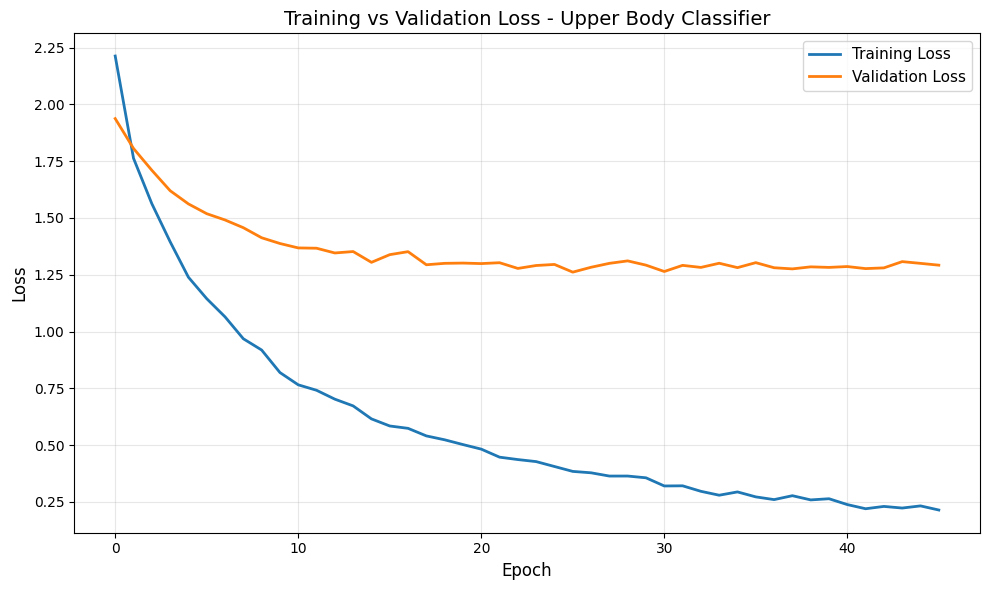

✅ Loss plot displayed


In [19]:
# Cell 12: Plot training history - Loss
print("📊 Generating loss plot...\n")

plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss", linewidth=2)
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training vs Validation Loss - Upper Body Classifier", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Loss plot displayed")


📊 Generating accuracy plot...



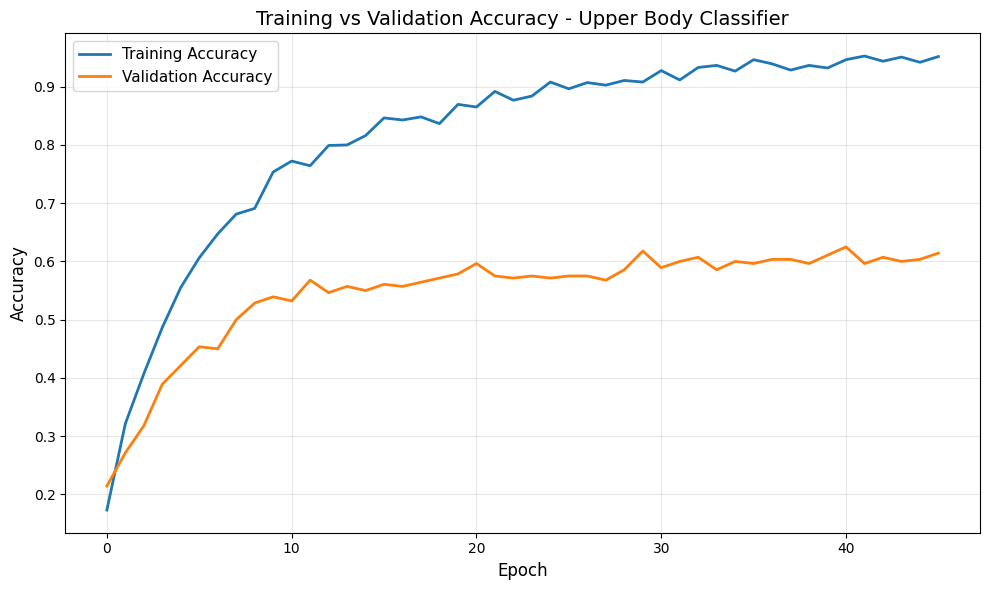

✅ Accuracy plot displayed


In [20]:
# Cell 13: Plot training history - Accuracy
print("📊 Generating accuracy plot...\n")

plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy", linewidth=2)
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training vs Validation Accuracy - Upper Body Classifier", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Accuracy plot displayed")


In [21]:
# Cell 14: Display final training results
print("\n" + "="*60)
print("📊 FINAL TRAINING RESULTS")
print("="*60 + "\n")

final_train_loss = history.history["loss"][-1]
final_train_acc = history.history["accuracy"][-1]
final_val_loss = history.history["val_loss"][-1]
final_val_acc = history.history["val_accuracy"][-1]

best_val_acc = max(history.history["val_accuracy"])
best_epoch = history.history["val_accuracy"].index(best_val_acc) + 1

print(f"Final Training Loss:        {final_train_loss:.4f}")
print(f"Final Training Accuracy:    {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"\nFinal Validation Loss:      {final_val_loss:.4f}")
print(f"Final Validation Accuracy:  {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"\nBest Validation Accuracy:   {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Best Epoch:                 {best_epoch}")
print(f"\nTotal Epochs Trained:       {len(history.history['loss'])}")
print(f"\nModel saved as:             {model_filename}")

print("\n" + "="*60)
print("🎉 UPPER BODY CLASSIFICATION MODEL TRAINING COMPLETE!")
print("="*60)



📊 FINAL TRAINING RESULTS

Final Training Loss:        0.2138
Final Training Accuracy:    0.9518 (95.18%)

Final Validation Loss:      1.2922
Final Validation Accuracy:  0.6143 (61.43%)

Best Validation Accuracy:   0.6250 (62.50%)
Best Epoch:                 41

Total Epochs Trained:       46

Model saved as:             /workspace/models/upper_body_classifier-mobilenetv2.h5

🎉 UPPER BODY CLASSIFICATION MODEL TRAINING COMPLETE!
